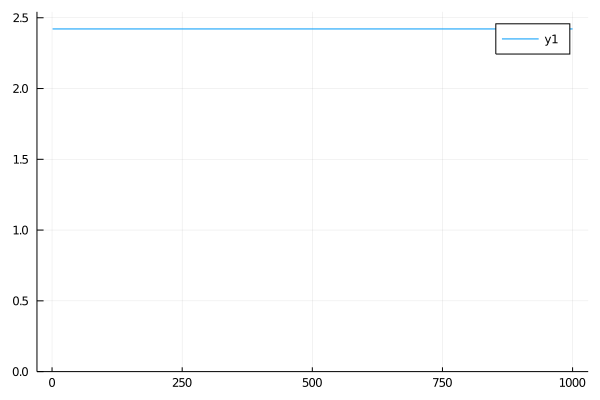

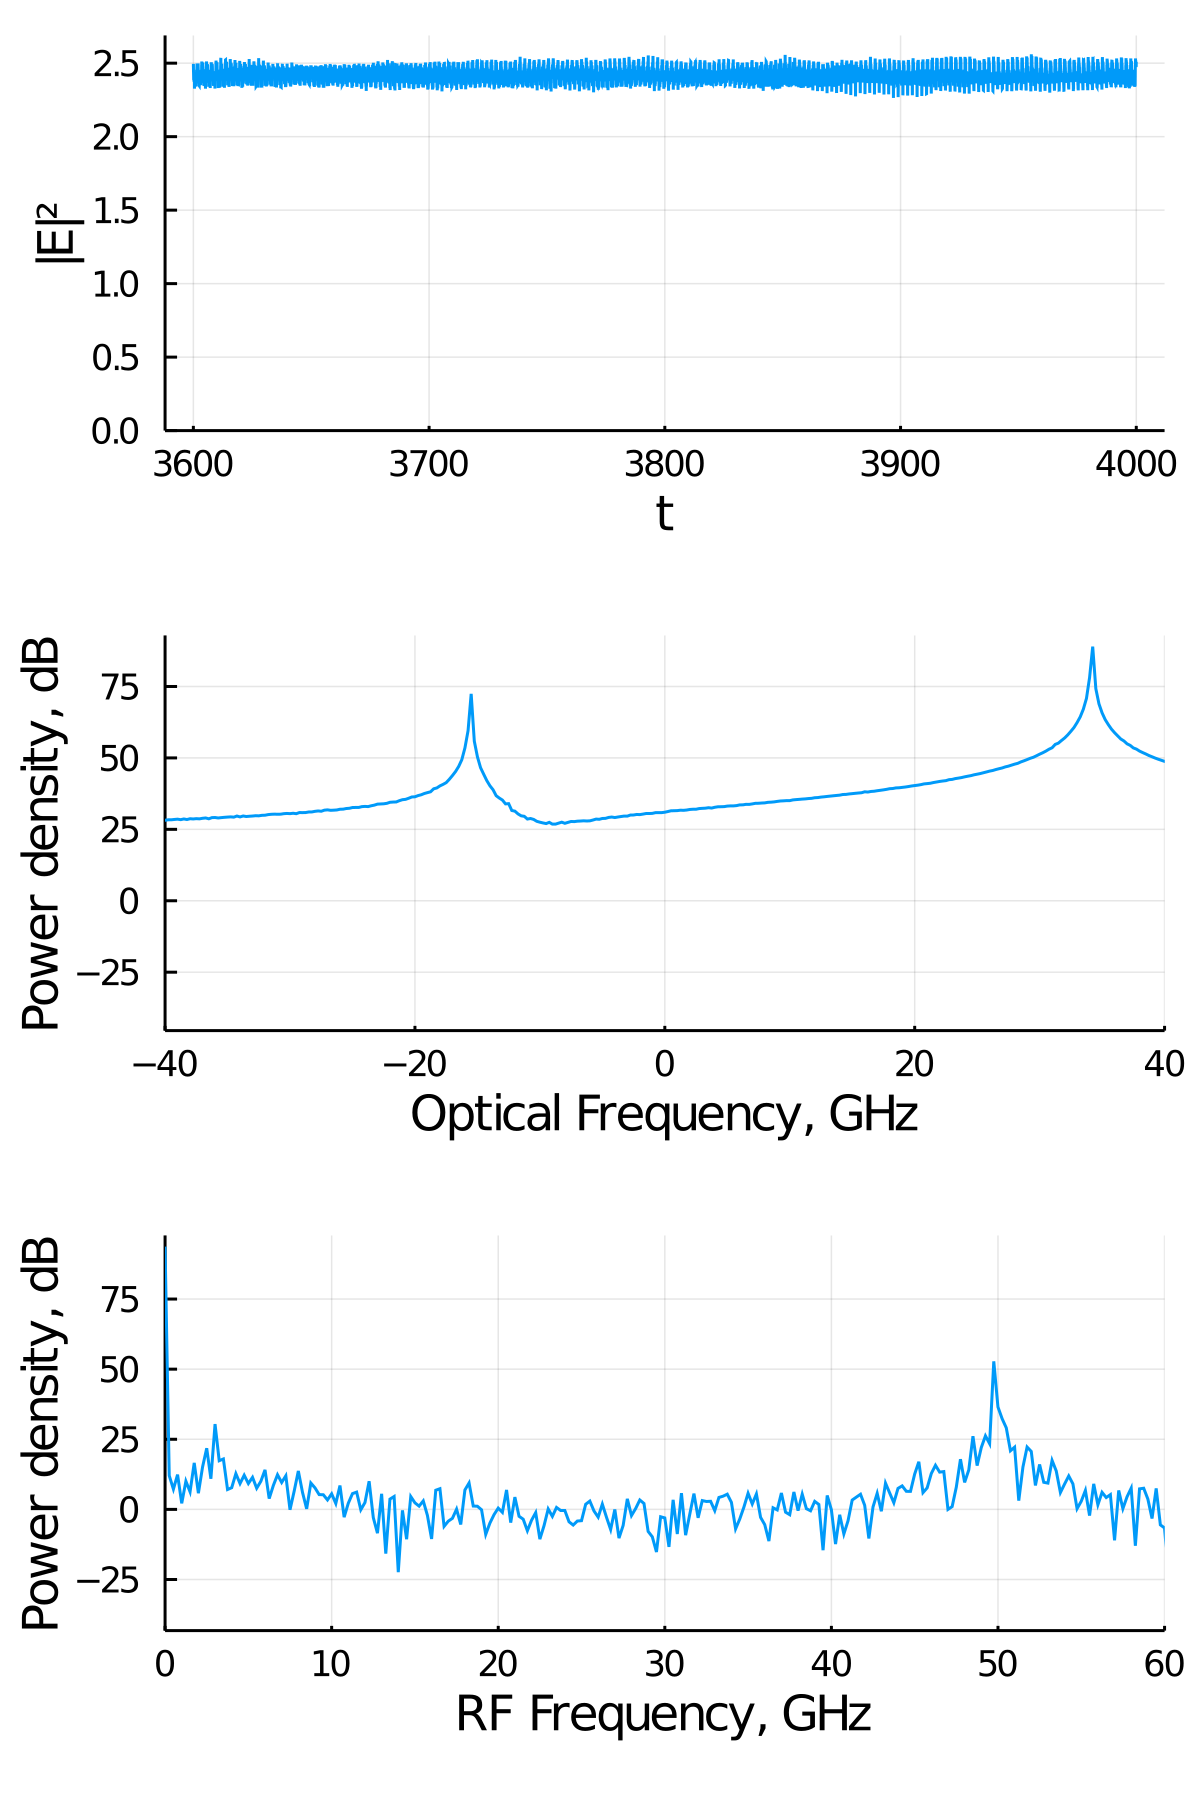

In [11]:
using Plots, Random, Roots, FFTW, LaTeXStrings

# cd(dirname(@__FILE__));

# parameters
gam0 = 100;
gamg0 = 0.01; # inverse is 1 ns physical
tau0 = 2;
alpha0 = 3; # меняется в задании 3
kap0 = 0.27;
phi0 = 0; # меняется в задании 1
g00rel = -log(kap0); # параметр накачки
g00 = g00rel * 6.0; # меняется в задании 2

tphys = 1 * 10^(-9) * gamg0;

# initial parameter vector
p0 = [gam0, gamg0, tau0, alpha0, kap0, phi0, g00];

t0 = 0;

# integration procedure parameters
dt = tau0 / 1000;
hist_len = floor(Int, tau0 / dt);
endtime = 2000 * tau0;
num_iter = floor(Int, endtime / dt);
dim = 3; # problem dimension
savnum = 100; # number of points per delay to save
modstep = floor(Int, hist_len / savnum);

# noise parameters
beta1 = 0.5 * 10^-3 / sqrt(dt); # noise in u[1]
beta2 = 0.5 * 10^-3 / sqrt(dt); # noise in u[2]

## function evaluating the derivatives for the iteration with the noise terms
# u is the dependent variables vector: u[1] is ℜ(E(t)), u[2] is ℑ(E(t)), u[3] is G(t)
# uT is the corresponding delayed dependent variables vector
# p is the parameter vector
# p[1] - gam
# p[2] - gamg
# p[3] - tau
# p[4] - alpha
# p[5] - kap
# p[6] - phi
# p[7] - g0
# nt are the Langevin noise terms vector

function VTmodel(u, uT, p, nt, t, t0)
    du1 =
        -p[1] * u[1] -
        exp(uT[3] / 2) *
        p[1] *
        sqrt(p[5]) *
        (
            -cos(p[6] + 0.5 * p[4] * uT[3]) * uT[1] -
            sin(p[6] + 0.5 * p[4] * uT[3]) * uT[2]
        ) + p[1] * nt[1]

    du2 =
        -p[1] * u[2] -
        exp(uT[3] / 2) *
        p[1] *
        sqrt(p[5]) *
        (
            sin(p[6] + 0.5 * p[4] * uT[3]) * uT[1] -
            cos(p[6] + 0.5 * p[4] * uT[3]) * uT[2]
        ) + p[1] * nt[2]

    du3 = p[2] * (p[7] - u[3] - (exp(u[3]) - 1) * (u[1]^2 + u[2]^2))

    return [du1, du2, du3]
end

## Semi-implicit Euler iteration procedure
# rhs should be the function of the form rhs(u,uT,p,nt,t,t0)
# SIEiters alterates qY, qYhead, qYtail and U
function SIEiters(rhs, num_iter, modstep, T, p, nt, qY1, qY2, qYtail, U)
    # dimensions
    dim = size(qY1, 1)
    # length of the stored history
    hist_len = size(qY1, 2)
    # array with the current intermediate values of the function
    Y1 = zeros(dim)
    Y2 = zeros(dim)
    # them delayed
    YT1 = zeros(dim)
    YT2 = zeros(dim)

    # local variable for the tail
    lqYtail = qYtail[1]

    # initial values of the unknown
    Y1 = qY1[:, lqYtail]

    # local time variables
    t0 = T[1]
    tc = T[2]
    dt = T[3]

    # fixed tau
    ft = floor(Int, p[3] / dt)

    # RK iterations
    for l = 1:num_iter
        # reading the time-delayed value of variables
        # the queue is stored in an array qY
        # the first index of qY is the number of the integration method subiteration
        # the second index is the point number inside the queue
        # the tail of the queue corresponds to the (t-dt) variables
        di = lqYtail - ft + 1
        if di < 1
            YT1 = qY1[:, hist_len+di]
            YT2 = qY2[:, hist_len+di]
        else
            YT1 = qY1[:, di]
            YT2 = qY2[:, di]
        end

        ntl = nt[l, :]

        # some semi-implicit calculations
        Y2 = Y1 + dt * rhs(Y1, YT1, p, ntl, tc, t0)

        # storing the time-delayed variables
        lqYtail = mod(lqYtail, hist_len) + 1
        qY1[:, lqYtail] = Y1
        qY2[:, lqYtail] = Y2

        # calculate the actual current-time variable
        Y1 = Y1 + dt * rhs(Y2, YT2, p, ntl, tc + dt, t0)

        # integration output
        if mod(l, modstep) == 0
            U[div(l, modstep), :] = Y1
        end

        tc = tc + dt
    end
    T[2] = tc
    qYtail[1] = lqYtail
end

## find a steady state as initial condition
# mode number
M = 0;
# function as an rhs for a equation solver
fsol(ws) =
    0.5 * (
        -2 * atan(ws / p0[1]) - 2 * ws * p0[3] -
        p0[4] * log((ws^2 + p0[1]^2) / (p0[1]^2 * p0[5]))
    ) - p0[6] + 2 * pi * M;

gsol(ws) = log((ws^2 + p0[1]^2) / (p0[1]^2 * p0[5]));

asol(gs) = sqrt(p0[7] - gs) / sqrt(-1 + exp(gs));

om = find_zero(fsol, 2 * pi * M / p0[3]);
gg = gsol(om);
amp = asol(gg);

# our initial history for SIE method subiterations
qY1 = zeros(dim, hist_len);
qY2 = zeros(dim, hist_len);
for i = 1:hist_len
    qY1[:, i] = [amp * cos(om * dt * (-i)), amp * sin(om * dt * (-i)), gg]
    qY2[:, i] = [amp * cos(om * dt * (1 - i)), amp * sin(om * dt * (1 - i)), gg]
end

display(plot(
    qY1[1, :] .^ 2 + qY1[2, :] .^ 2,
    ylims = (0, 1.05 * maximum(qY1[1, :] .^ 2 + qY1[2, :] .^ 2)),
))

## integration
U = zeros(div(num_iter, modstep), dim)

qYtail = [1];

Random.seed!(1234)

time_array = [t0, t0, dt]

# noise terms
nt = zeros(num_iter, 2)
nt[:, 1] = beta1 * randn(num_iter)
nt[:, 2] = beta2 * randn(num_iter)

SIEiters(VTmodel, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U)

pl_st_t = endtime - 200 * tau0;
pl_en_t = endtime;
n = 3000; # number of timepoints for plot
pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
pl_en_in = div(floor(Int, pl_en_t / dt), modstep);
pl_step = max(1, div(floor(Int, (pl_en_in - pl_st_in) / n), modstep));
forplot = (
    U[pl_st_in:pl_step:pl_en_in, 1] .^ 2 + U[pl_st_in:pl_step:pl_en_in, 2] .^ 2
);
ts = collect(range(pl_st_t, stop = pl_en_t, length = length(forplot)));
p1 = plot(
    ts,
    forplot,
    ylims = (0, 1.05 * maximum(forplot)),
    xlabel = "t",
    ylabel = "|E|²",
    legend = false,
);

# optical spectrum
optfreq =
    fftshift(fftfreq(
        length(U[pl_st_in:pl_en_in, 1]),
        1 / (dt * modstep * tphys),
    )) ./ 10^9;
optspec =
    10 *
    log10.(abs2.(fftshift(fft(
        U[pl_st_in:pl_en_in, 1] + im * U[pl_st_in:pl_en_in, 2],
    ))));

# rf spectrum
rffreq =
    rfftfreq(length(U[pl_st_in:pl_en_in, 1]), 1 / (dt * modstep * tphys)) ./
    10^9;
rfspec =
    10 *
    log10.(abs2.(rfft(
        U[pl_st_in:pl_en_in, 1] .^ 2 + U[pl_st_in:pl_en_in, 2] .^ 2,
    )));

p2 = plot(
    optfreq,
    optspec,
    xlabel = "Optical Frequency, GHz",
    xlims = (-40, 40),
    ylabel = "Power density, dB",
    legend = false,
)
p3 = plot(
    rffreq,
    rfspec,
    xlabel = "RF Frequency, GHz",
    xlims = (0, 60),
    ylabel = "Power density, dB",
    legend = false,
)

pall = plot(p1, p2, p3, layout = (3, 1), size = (400, 600), dpi = 300)

display(pall)

savefig(pall, "results.png")

GC.gc()
